# [題目]
使用 RNN 實作手寫數字辨識
在 ImageRNN 類別裡面輸入 PyTorch 內建的 RNN class 完成 ImageRNN 的實作，讓程式可以順利執行，並且準確度高達 90% 以上

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchvision.utils as utils
import torchvision.datasets as dsets
import torchvision.transforms as transforms

In [2]:
# 超參數 Hyperparameter
EPOCH = 5   # train the training data n times, to save time, we just train 1 epoch
BATCH_SIZE = 64
TIME_STEP = 28   # rnn time step / image height
INPUT_SIZE = 28   # rnn input size / image width
LR = 0.001   # learning rate
DOWNLOAD_MNIST = True   # set to True if haven't download the data

# 載入手寫數字資料集 Mnist digital dataset
train_data = dsets.MNIST(
    root='mnist',
    train=True,   # this is training data
    transform=transforms.ToTensor(),   # Converts a PIL.Image or numpy.ndarray to
                                       # torch.FloatTensor of shape (C x H x W) and normalize in the range [0.0, 1.0]
    download=DOWNLOAD_MNIST,   # download it if you don't have it
)

Extracting mnist/MNIST/raw/train-images-idx3-ubyte.gz to mnist/MNIST/raw


Extracting mnist/MNIST/raw/train-labels-idx1-ubyte.gz to mnist/MNIST/raw



Extracting mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist/MNIST/raw


Extracting mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [3]:
print(train_data.data.size())   # (60000, 28, 28)
print(train_data.targets.size())   # (60000)

torch.Size([60000, 28, 28])
torch.Size([60000])


In [4]:
train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)

# convert test data into Variable, pick 2000 samples to speed up testing
test_data = dsets.MNIST(root='mnist', train=False, transform=transforms.ToTensor())
test_x = test_data.data.type(torch.FloatTensor)[:2000] / 255.   # shape (2000, 28, 28) value in range(0,1)
test_y = test_data.targets.numpy()[:2000]   # covert to numpy array

test_loader = torch.utils.data.DataLoader(dataset=test_data, batch_size=BATCH_SIZE, shuffle=True)

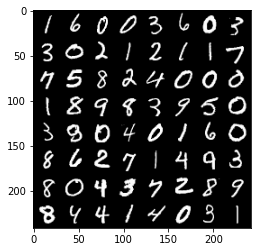

In [5]:
# Exploring the dataset

# functions to show an image
def imshow(img):
    # img = img / 2 + 0.5   # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
imshow(utils.make_grid(images))

In [6]:
# parameters
N_NEURONS = 150
N_OUTPUTS = 10

In [7]:
class ImageRNN(nn.Module):
    def __init__(self, batch_size, n_steps, n_inputs, n_neurons, n_outputs):
        super(ImageRNN, self).__init__()
        
        self.n_neurons = n_neurons
        self.batch_size = batch_size
        self.n_steps = n_steps
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs
        
        # 請查看PyTorch文件，選用最基本的RNN來當作模型
        self.basic_rnn = nn.RNN(input_size=n_inputs, hidden_size=n_neurons)
        
        self.FC = nn.Linear(self.n_neurons, self.n_outputs)
        
    def forward(self, X):
        # transforms X to dimensions: (n_steps, batch_size, n_inputs)
        X = X.permute(1, 0, 2)
        
        self.batch_size = X.size(1)

        rnn_out, self.hidden = self.basic_rnn(X)
        out = self.FC(self.hidden)
        
        return out.view(-1, self.n_outputs)   # (batch_size, n_output)

In [8]:
import torch.optim as optim

# use gpu if cuda is available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Model instance
model = ImageRNN(BATCH_SIZE, TIME_STEP, INPUT_SIZE, N_NEURONS, N_OUTPUTS)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

def get_accuracy(logit, target, batch_size):
    ''' Obtain accuracy for training round '''
    corrects = (torch.max(logit, 1)[1].view(target.size()) == target).sum()
    accuracy = 100.0 * corrects / batch_size

    return accuracy.item()

# loop over the dataset multiple times
for epoch in range(EPOCH):
    train_running_loss = 0.0
    train_acc = 0.0
    model.train()
    
    # TRAINING ROUND
    for i, data in enumerate(train_loader):
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # get the inputs
        inputs, labels = [x.to(device) for x in data]
        inputs = inputs.view(-1, 28, 28) 

        # forward + backward + optimize
        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_running_loss += loss.item()
        train_acc += get_accuracy(outputs, labels, BATCH_SIZE)
         
    model.eval()
    print(f"Epoch: {epoch} | Loss: {train_running_loss / i:.4f} | Train Accuracy: {train_acc / i:.2f}")

Epoch: 0 | Loss: 0.6593 | Train Accuracy: 78.72
Epoch: 1 | Loss: 0.2856 | Train Accuracy: 91.84
Epoch: 2 | Loss: 0.2137 | Train Accuracy: 94.01
Epoch: 3 | Loss: 0.1817 | Train Accuracy: 94.88
Epoch: 4 | Loss: 0.1537 | Train Accuracy: 95.70


In [9]:
# Calculate test accuracy
test_acc = 0.0
for i, data in enumerate(test_loader, 0):
    inputs, labels = [x.to(device) for x in data]
    inputs = inputs.view(-1, 28, 28)

    outputs = model(inputs)

    test_acc += get_accuracy(outputs, labels, BATCH_SIZE)
        
print(f"Test Accuracy: {test_acc / i:.2f}")

Test Accuracy: 95.48
